# Read in the datasets into a dictionary

In [33]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [34]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [35]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [36]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [37]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [38]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [39]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [40]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [41]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [42]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

# Investigate correlations between SAT scores and school surveys

In [43]:
%matplotlib inline

In [44]:
var_list = survey_fields
var_list.append('sat_score')

In [49]:
survey_subset = combined[var_list]
correlations = survey_subset.corr()
correlations = correlations["sat_score"]
correlations = correlations[:-1]

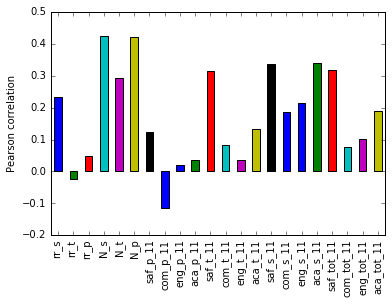

In [50]:
ax = correlations.plot.bar()
ax.set_ylabel("Pearson correlation")

## The SAT score is in general positively correlated with student survey results, less so with the teacher survey results, and not very correlated with the parent survey results. 

# Look more into correlations with saf_t_11 and saf_s_11 which measure how teachers and students perceive safety at school

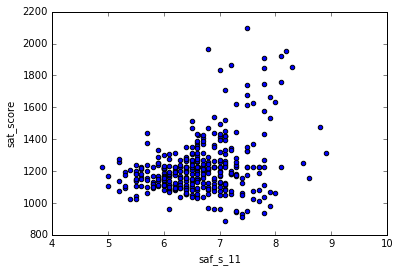

In [51]:
combined.plot.scatter("saf_s_11","sat_score")

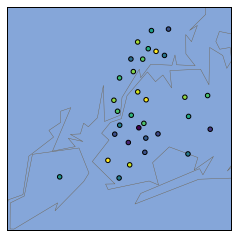

In [52]:
# map out safety scores by district
districts = combined.groupby("school_dist").agg(numpy.mean)

from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='blue', linewidth=.4)

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()

m.scatter(x=longitudes,y=latitudes,latlon=True,
          s=20,zorder=2,c=districts["saf_s_11"],
          cmap="viridis")
# lighter colors have higher student safety ratings

## Most lower safety ratings are in northern Brooklyn, with higher safety ratings in southern Brooklyn and in Manhattan (?...I'm not too familiar with the borough boundaries in NY) 

# Look into correlations with racial percentages and SAT score

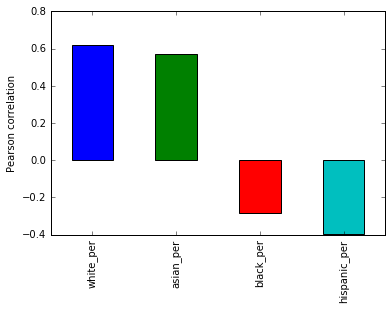

In [53]:
# bar plot of correlations
var_list = ["sat_score","white_per","asian_per","black_per","hispanic_per"]
survey_subset = combined[var_list]
correlations = survey_subset.corr()
correlations = correlations["sat_score"]
correlations = correlations[["white_per","asian_per","black_per","hispanic_per"]]
ax = correlations.plot.bar()
ax.set_ylabel("Pearson correlation")

## As suspected, whites and asians are strongly correlated to have higher SAT scores, and blacks and hispanics have lower SAT scores (the negative correlation with black percent is weak though).  Probably some complicated socioeconomics is at play.

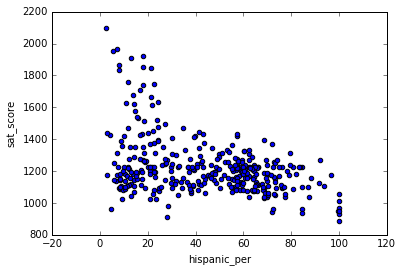

In [54]:
# look at schools with low SAT scores and high hispanic_per by
# making a scatterplot
combined.plot.scatter(x="hispanic_per",y="sat_score")

In [55]:
# get school names for schools with hispanic_per > 95%
school_names = combined[combined["hispanic_per"]>95]["School Name"]
print(school_names)

44             MANHATTAN BRIDGES HIGH SCHOOL
82                                         0
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIE
125                                        0
141    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176                                        0
253                MULTICULTURAL HIGH SCHOOL
286    PAN AMERICAN INTERNATIONAL HIGH SCHOO
Name: School Name, dtype: object


## Looks like three of the schools with `hispanic_per` > 95% have missing names.  Based on google searches, the other schools specifically cater to recent immigrants so it makes sense that these students have lower SAT scores (since for example, they are adjusting to a new life in America and speaking English, etc.).

In [56]:
# take a look at schools with hispanic_per < 10% and 
# sat_score > 1800
school_names = combined[(combined["hispanic_per"]<10) & (combined["sat_score"]>1800)]["School Name"]
print(school_names)

37                    STUYVESANT HIGH SCHOOL
151             BRONX HIGH SCHOOL OF SCIENCE
187           BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES A
356      STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: School Name, dtype: object


## All of these schools seem to be elite technical schools that specialize in math and science.

# Investigate gender differences in SAT scores

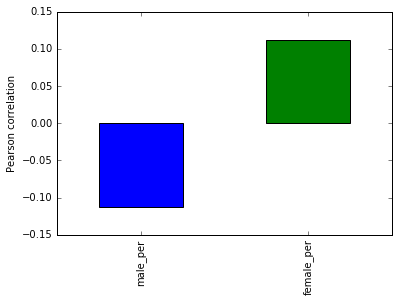

In [57]:
# bar plot of correlations
var_list = ["sat_score","male_per","female_per"]
survey_subset = combined[var_list]
correlations = survey_subset.corr()
correlations = correlations["sat_score"]
correlations = correlations[["male_per","female_per"]]
ax = correlations.plot.bar()
ax.set_ylabel("Pearson correlation")

## There is a very weak negative correlation of the SAT score with male percent and a very weak positive correlation with female percent.

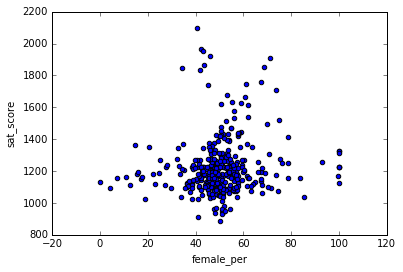

In [60]:
# make a scatter plot of female_per vs. sat_score
combined.plot.scatter(x="female_per",y="sat_score")

## seems like schools with very low and very high female percentages seem to have low SAT scores!  Some of the schools with a female percent around 30-80% produce high average SAT scores.

In [61]:
# research schools with female_per > 60 and SAT score >
# 1700
school_names = combined[(combined["female_per"]>60) & (combined["sat_score"]>1700)]["School Name"]
print(school_names)

5            BARD HIGH SCHOOL EARLY COLLEGE
26            ELEANOR ROOSEVELT HIGH SCHOOL
60                       BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF
302             TOWNSEND HARRIS HIGH SCHOOL
Name: School Name, dtype: object


## In general these schools appear to be elite schools which cater toward a liberal arts/performing arts/humanities education.

# Investigate the relationship between the number of AP test-takers and SAT scores

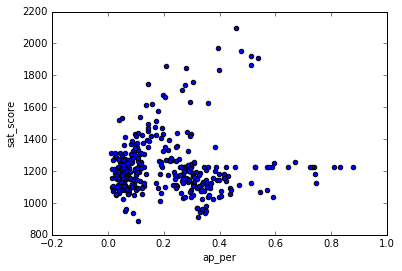

In [65]:
# total enrollment is highly correlated with SAT score
# calculate percentage of students in each school that
# took an AP exam and examine the correlation of this
# percent with the SAT score

#combined.columns
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]
combined.plot.scatter(x="ap_per",y="sat_score")

##  It looks like there is some positive correlation between the percent of students taking AP tests and the average SAT score.  For example, schools with an average SAT score > 1800 tend to have a percent of AP test takers >  20%.